In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/nfshomes/mukunds/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
yolo_model = YOLO('../WHAM/checkpoints/yolov8x.pt')

In [163]:
img = Image.open('video_samples_yolo/sample_7/frames/0.jpg')

In [164]:
# # bbox detection
bboxes = yolo_model.predict(
    img, device=torch.device('cuda'), classes=0, conf=0.75, save=False, verbose=False
)[0].boxes.xyxy.detach().cpu().numpy()

bboxes = [{'bbox': bbox} for bbox in bboxes]

In [165]:
bbox = bboxes[0]['bbox']

horizontal_mid = (bbox[0] + bbox[2]) / 2
top_third = (bbox[1] + bbox[3]) / 3
bottom_third = (bbox[1] + bbox[3]) * 2 / 3

pt1 = [horizontal_mid, top_third]
pt2 = [horizontal_mid, bottom_third]

In [166]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

using device: cuda


In [167]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [168]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

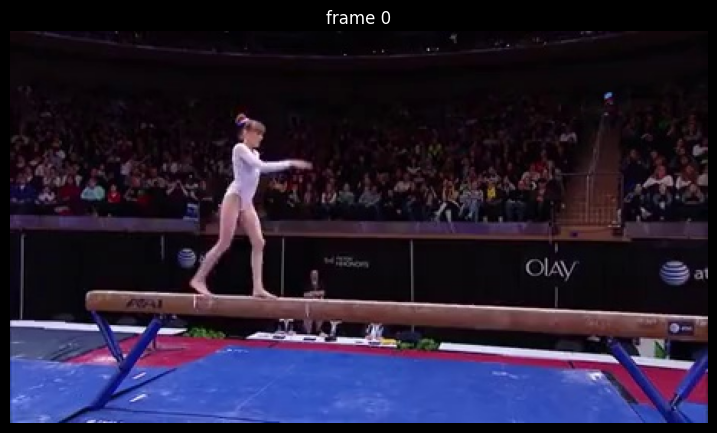

In [169]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./video_samples_yolo/sample_7/frames"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.axis('off')
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
plt.show()

In [170]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG):  16%|█████████████████████████▉                                                                                                                                       | 5/31 [00:00<00:00, 47.44it/s]

frame loading (JPEG): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 46.60it/s]


In [171]:
predictor.reset_state(inference_state)

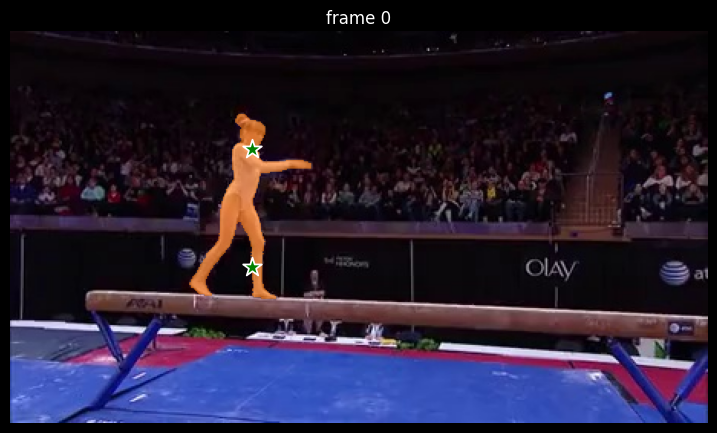

In [172]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a 2nd positive click at (x, y) = (250, 220) to refine the mask
# sending all clicks (and their labels) to `add_new_points_or_box`
points = np.array([pt1, pt2], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1, 1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
plt.axis('off')
plt.show()

propagate in video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:03<00:00,  8.77it/s]


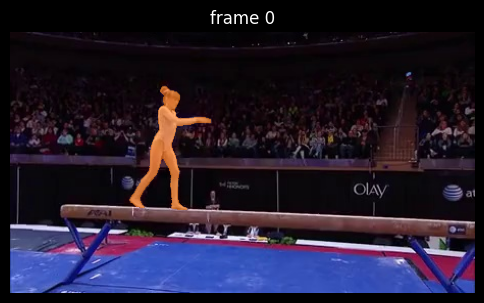

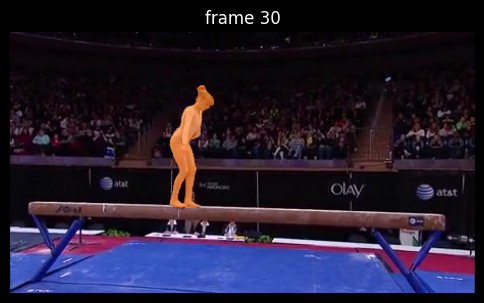

In [173]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.axis('off')
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)
        plt.show()

In [174]:
def get_bbox_from_mask(mask):
    """
    Calculate the bounding box (xmin, ymin, xmax, ymax) for the given mask.

    Args:
        mask (numpy.ndarray): The binary mask array (2D).

    Returns:
        tuple: The bounding box as (xmin, ymin, xmax, ymax), or None if mask is empty.
    """
    mask = np.squeeze(mask)
    
    rows, cols = np.where(mask)
    ymin, ymax = rows.min(), rows.max()
    xmin, xmax = cols.min(), cols.max()

    return xmin, ymin, xmax, ymax


In [175]:
all_pts = []
for i in range(len(video_segments)):
    frame_mask = video_segments[i][1]
    xmin, ymin, xmax, ymax = get_bbox_from_mask(frame_mask)
    all_pts.append(np.array([xmin, ymin, xmax, ymax]))
all_pts = np.array(all_pts)

In [176]:
np.save("video_samples_yolo/sample_7/sample_7_bboxes.npy", all_pts)

In [177]:
# import cv2
# import matplotlib.pyplot as plt

# # Example inputs
# image_path = "video_samples/sample_3/frames/24.jpg"  # Path to your image
# image = cv2.imread(image_path)  # Load the image (BGR format)
# bbox = (xmin, ymin, xmax, ymax)  # Replace with actual bbox values

# # Convert the image from BGR to RGB format for matplotlib
# image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Draw the bounding box on the image
# cv2.rectangle(
#     image_rgb,
#     (bbox[0], bbox[1]),  # Top-left corner (xmin, ymin)
#     (bbox[2], bbox[3]),  # Bottom-right corner (xmax, ymax)
#     color=(255, 0, 0),   # Red color in RGB format
#     thickness=2          # Line thickness
# )

# # Display the image with bounding box using matplotlib
# plt.figure(figsize=(10, 6))
# plt.imshow(image_rgb)
# plt.axis('off')  # Hide axes for a cleaner view
# plt.title("Image with Bounding Box")
# plt.show()


In [178]:
torch.cuda.empty_cache()
del predictor
torch.cuda.empty_cache()